In [ ]:
pip install optuna # optuna is a library to tune hyperparameters more efficiently

# Methodology

The time series data consists of sales values from 10 different stores and 50 different items. This causes every timestamp to repeat 500 times. We can use data in this format and build a model (using XGBoost) in order to make forecasting for future sales, individually for very item and every store.

We can input the data directly into XGBoost algorithm and get the forecast.

The experiments were also tried with Random forest but the algorithm takes a long time to train, so XGBoost was chosen.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from time import time
import pickle

In [ ]:
# loading data using pandas

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Feature Engineering

The feature engineering here is done in the following steps:

1. Convert the date into datetime format which is easily understood by pandas and use this feature as index of the DataFrame.
2. Date related features such as month, day, week, quarter and other elements were chosen. This is important because we do not have any domain related features that we can use to build features. Also, date related features are easy to construct.
3. Total 11 different features relating to date were added. The temporal information comes from these features.

In [ ]:
def datetime(df):
  '''
  Method to convert the date column which 
  would be easily understood by pandas
  '''
  df.date = pd.to_datetime(df.date).values
  temp = df.set_index('date', drop=True)

  return temp

train = datetime(train)
test = datetime(test)

In [ ]:
# Feature engineering

'''
Using date as X feature and sales as y feature
'''

def date_related_features(df):
  '''
  Converts date feature into smaller parts and 
  adds as additional features to the dataset
  '''
  df['day_in_month'] = np.array(df.index.day.values) # number of days in the month
  df['month'] = np.array(df.index.month.values) # adds month feature
  df['day_in_year'] = np.array(df.index.dayofyear.values) # number of days in the year
  df['day_of_week'] = np.array(df.index.dayofweek.values) # day numbers in the week
  df['week_in_year'] = np.array(df.index.isocalendar().week.values).astype('int') # week numbers in the year
  df['date_diff'] = np.array((df.index - df.index[0]).days) # no. of days from start
  df['quarter'] = np.array(df.index.quarter) # date belongs to which quarter of year
  df['weekend'] = np.array(np.floor_divide(df.index.dayofweek,4)) # if its a weekend or not
  df['year'] = np.array(df.index.year) # date belongs to which quarter of year
  df['monthstart'] = np.array(df.index.is_month_start.astype(int)) # 1 if the day is start of month
  df['monthend'] = np.array(df.index.is_month_end.astype(int)) # 1 if the day is start of month

  return df

train = date_related_features(train)
test = date_related_features(test)

In [ ]:
train.shape

(913000, 14)

In [ ]:
train.tail()

,store,item,sales,day_in_month,month,day_in_year,day_of_week,week_in_year,date_diff,quarter,weekend,year,monthstart,monthend
date,,,,,,,,,,,,,,
2017-12-27,10,50,63,27,12,361,2,52,1821,4,0,2017,0,0
2017-12-28,10,50,59,28,12,362,3,52,1822,4,0,2017,0,0
2017-12-29,10,50,74,29,12,363,4,52,1823,4,1,2017,0,0
2017-12-30,10,50,62,30,12,364,5,52,1824,4,1,2017,0,0
2017-12-31,10,50,82,31,12,365,6,52,1825,4,1,2017,0,1


In [ ]:
test.head()

,id,store,item,day_in_month,month,day_in_year,day_of_week,week_in_year,date_diff,quarter,weekend,year,monthstart,monthend
date,,,,,,,,,,,,,,
2018-01-01,0,1,1,1,1,1,0,1,0,1,0,2018,1,0
2018-01-02,1,1,1,2,1,2,1,1,1,1,0,2018,0,0
2018-01-03,2,1,1,3,1,3,2,1,2,1,0,2018,0,0
2018-01-04,3,1,1,4,1,4,3,1,3,1,0,2018,0,0
2018-01-05,4,1,1,5,1,5,4,1,4,1,1,2018,0,0


# Preprocessing Data

The preprocessing is done in following steps:

1. The data is split into train and validation. For validation, last 3 months of train set were chosen. This split is similar to the one with LSTM method.
2. Validation set is used for tuning hyperparameters.

In [ ]:
# data split: train and validation

'''
The last 3 months of the train data are used as validation set
The test set also consists of 3 months related data
'''

df_train = train.iloc[train.index < "2017-10-01", :]

df_valid = train.iloc[train.index >= "2017-10-01", :]

In [ ]:
'''
X features and y features are separated for train and valid data
'''

feature_columns = [i for i in train.columns if i not in ['id', "sales"]]

x_train = df_train[feature_columns]
y_train = df_train.sales

x_valid = df_valid[feature_columns]
y_valid = df_valid.sales

In [ ]:
x_train.shape

(867000, 13)

# Model Training

1. XGBoost regressor was chosen with two hyperparameters namely, *max_depth* and *n_estimators*.
2. Optuna integration on the model makes it very simple to tune the hyperparameters based on the validation score. The validation metric that's chosen here is Mean Absolute Error (MAE). We run trials and choose the hyperparameters based on how quicker the algorithm converges to the optimal value.
3. For MAE, our objective is to minimize the metric.
4. After all the trials, we pick the best model which gives the least validation score (MAE) and this model is used to forecast sales values on test data.
5. Optuna shows the most important hyperparameter which helped the method to converge quickly to the optimal solution.
6. Metrics like MAE, RMSE (Root Mean Squared Error), and R Squared are used to judge the performance of the best regression model on validation data. As one metric does not tell the same story, it is better to use multiple metrics which have its pros and cons.

In [ ]:
'''
Optuna picks the hyperparameters based on the step size and begins to do trials by
selecting random hyperparameters at first and as we calculate the metrics, it tries to
select hyperparameters which will minimize/ maximize the given metric.

In our case, we used the RMSE metric which should be minimized.
'''

def objective(trial):

  max_depth = trial.suggest_int("max_depth", 3, 12,step=3, log=False)
  n_estimators = trial.suggest_int("n_estimators", 100, 300,step=100, log=False)

  model = xgboost.XGBRegressor(objective ='reg:squarederror',max_depth=max_depth,n_estimators=n_estimators)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_valid)


  # Handle pruning based on the intermediate value
  if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

  trial.set_user_attr(key="best_booster", value=model)
  return mean_absolute_error(y_valid, y_pred)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=None, callbacks=[callback])

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = study.best_trial.params

[I 2021-07-24 17:42:15,102] A new study created in memory with name: no-name-06437eb1-3b01-4bb7-88dd-2421526d755e
[I 2021-07-24 17:54:06,824] Trial 0 finished with value: 6.499211006745048 and parameters: {'max_depth': 12, 'n_estimators': 300}. Best is trial 0 with value: 6.499211006745048.
[I 2021-07-24 17:55:48,509] Trial 1 finished with value: 7.534262887436411 and parameters: {'max_depth': 6, 'n_estimators': 100}. Best is trial 0 with value: 6.499211006745048.
[I 2021-07-24 17:58:32,119] Trial 2 finished with value: 6.404616967688436 and parameters: {'max_depth': 9, 'n_estimators': 100}. Best is trial 2 with value: 6.404616967688436.
[I 2021-07-24 18:02:03,680] Trial 3 finished with value: 6.540678252748821 and parameters: {'max_depth': 6, 'n_estimators': 200}. Best is trial 2 with value: 6.404616967688436.
[I 2021-07-24 18:02:56,560] Trial 4 finished with value: 12.551179811270341 and parameters: {'max_depth': 3, 'n_estimators': 100}. Best is trial 2 with value: 6.404616967688436.

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial:
  Value:  6.216989140583121
  Params: 
    max_depth: 9
    n_estimators: 200


In [ ]:
'''
Using the best model from the optuna trials 
to get the RMSE and R2 metrics
'''

best_model = study.user_attrs['best_booster']
y_pred = best_model.predict(x_valid)

pickle.dump(best_model, open('saved_models/xgboost.model', 'wb'))

print('MAE: ',mean_absolute_error(y_pred, y_valid))
print('RMSE: ',sqrt(mean_squared_error(y_pred, y_valid)))
print('R2: ',r2_score(y_pred, y_valid))

MAE:  6.216989140583121
RMSE:  8.025594273188979
R2:  0.9156190407005195


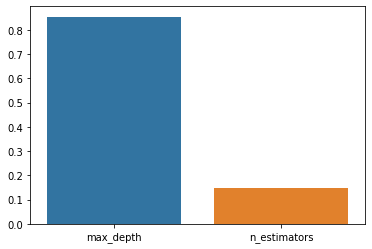

In [ ]:
'''
Optuna shows the hyperparameter importance 
i.e, which hyperparameter was more useful in reaching the optimal solution

In this case, we found that max_depth was more important.
The experiment can be rerun based on these insights with more trials
'''

D = optuna.importance.get_param_importances(study)
plt.figure()
sns.barplot(x = list(D.keys()),y =  list(D.values()))

In [ ]:
y_pred_test = best_model.predict(test.drop(['id'],axis=1))
y_pred_test = y_pred_test.astype('int')

# saving test predictions
test_original = pd.read_csv("data/test.csv")
test_original['predicted_sales'] = y_pred_test
test_original.to_csv('predictions_xgboost.csv', index=False)

test_original.head()

,id,date,store,item,predicted_sales
0,0,2018-01-01,1,1,12
1,1,2018-01-02,1,1,11
2,2,2018-01-03,1,1,9
3,3,2018-01-04,1,1,10
4,4,2018-01-05,1,1,12


# Plots relating to Sales forecast on validation set and test set

Since there are lots of examples (stores and items), first plot shows the plot of one store and one item (specifically store 1, item 1) of validation set (actual and predicted)

Second plot aggregates the sales values of every store and item to make a visualization of sales values of all stores and items (of validation set (actual and predicted))

Third plot shows sales values and predictions on validation and test set, along with the visualization for train set sales values

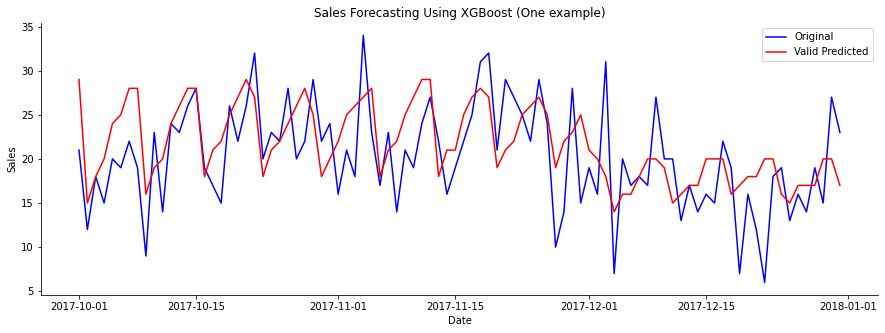

In [ ]:
'''
Plot showing sales values of one store and one item
'''
test_original = datetime(test_original)
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data= df_valid[(df_valid['store']==1) & (df_valid['item']==1)].sales, ax=ax, 
              label='Original', color='blue')
sns.lineplot(data=df_valid[(df_valid['store']==1) & (df_valid['item']==1)].pred_value, ax=ax, 
              label='Valid Predicted', color='Red')


ax.set(xlabel = "Date",
        ylabel = "Sales",
        title = "Sales Forecasting Using XGBoost (One example)")

ax.legend()
plt.savefig( 'images/xgboost-train-valid-single.jpg', bbox_inches='tight', dpi=200)


sns.despine()

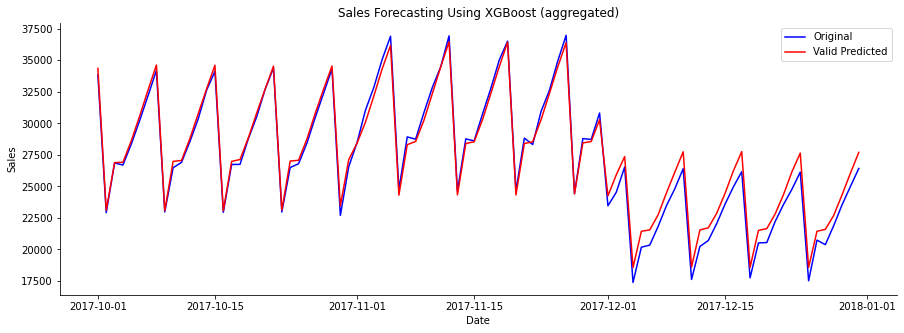

In [ ]:
'''
Visualization of aggregated sales values

The model performs better for global/ aggregated insights than
individual forecasts.
'''

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=df_valid.resample('D').sum().sales, ax=ax, 
              label='Original', color='blue')
sns.lineplot(data=df_valid.resample('D').sum().pred_value, ax=ax, 
              label='Valid Predicted', color='Red')


ax.set(xlabel = "Date",
        ylabel = "Sales",
        title = "Sales Forecasting Using XGBoost (aggregated)")

ax.legend()
plt.savefig( 'images/xgboost-train-valid-agg.jpg', bbox_inches='tight', dpi=200)

sns.despine()

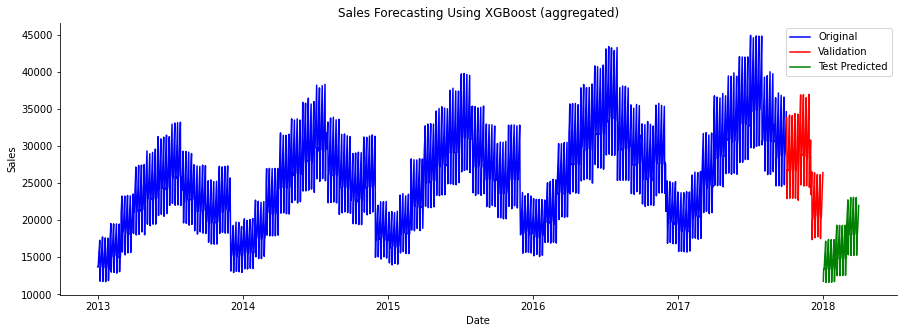

In [ ]:
'''
Visualization of aggregated sales values of train, valid and test sets

The model performs better for global/ aggregated insights than
individual forecasts.
'''

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=df_train.resample('D').sum().sales, ax=ax, 
              label='Original', color='blue')
sns.lineplot(data=df_valid.resample('D').sum().sales, ax=ax, 
              label='Validation', color='Red')
sns.lineplot(data=test_original.resample('D').sum().predicted_sales, ax=ax, 
              label='Test Predicted', color='green')


ax.set(xlabel = "Date",
        ylabel = "Sales",
        title = "Sales Forecasting Using XGBoost (aggregated)")

ax.legend()
plt.savefig( 'images/xgboost-alldata.jpg', bbox_inches='tight', dpi=200)

sns.despine()